<h1 style="text-align: center">College Tuition vs. Starting Salary (Ohio)</h1>

A few months ago, [Machine Learning Plus](https://www.machinelearningplus.com/) published [a great article](https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/) demonstrating the power of matplotlib by showcasing 50 cool visuals you can accomplish with the package.  Inspired, I wanted to see if I could replicate some of these visuals, but with data I'm interested in.

So, I started with their [bubble chart](https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/#2.-Bubble-plot-with-Encircling), but instead of using the strange, [Midwest data](https://raw.githubusercontent.com/selva86/datasets/master/midwest_filter.csv) they used, I thought I'd work in a space that's been preoccupying my time of late: college tuition.  What sort of bubble chart could I craft that depicted college tuition in some way?  What about a bubble chart depicting the intersection of college tuitions and their corresponding average starting salaries?  That might help parents and students better understand the return on investment associated with various colleges.

First, I decided to narrow down my work to just Ohio colleges.  At [Payscale.com](https://www.payscale.com), I found [a dataset of median starting salaries by Ohio college for 2018](https://www.payscale.com/college-salary-report/best-schools-by-state/bachelors/ohio). 

Unfortunately, the Payscale.com dataset did nto include college tuition prices.  However, [CollegeCalc.org](http://www.collegecalc.org) did have [a dataset of Ohio college tuition prices for 2018-2019](http://www.collegecalc.org/colleges/ohio/?view=all).

Much of my work revolved around cleaning up these data sources and merging them together for the final visual.  As you might imagine, each dataset tended to have slight name variations between schools.  For example, the Payscale.com dataset had an entry for *Kettering College* whereas the CollegeCalc.org site calls that school *Kettering College of Medical Arts*.  So, I had to do a fair amount of work making sure both datasets called each school the same name so that I could properly match on those names.

The Payscale.com dataset included some language to differentiate public schools from private, which I used to color my bubbles blue and red, respectively.  The CollegeCalc.org dataset included the school size which I used to size each bubble.

Machine Learning Plus's bubble chart includes a cool "encircling" device that draws a circle around certain datapoints to draw the user's attention to those points.  Instead of doing that, I thought it'd be interesting to draw a "break even" line.  All things equal, if you pay, say, \$10,000 in tuition for 4 years, you're tuition investment would break even if your first job out of school paid \$40,000.  I drew a line to that effect on the graph: datapoints above that line would have a positive return on investment whereas datapoints below that line would have a negative return on investment.  I didn't want to muddy up the chart labeling each bubble with the name of the college, but I still thought it'd be fun to calculate which schools are above and below the line, so [I found a way to do that](https://stackoverflow.com/questions/39840030/distance-between-point-and-a-line-from-two-points), added the calculation as a column to the dataframe, and printed out the Top 5 "Best" returns on investment and the Top 5 "Worse" returns on investment.

Obviously, my "break even" assessment is *very* simplistic.  There are many other variables I don't account for: room and board, fees, financial aid, merit scholarships, and the like.  The median starting salaries are across all graduates from a given school--from Philosophy majors to Computer Science.  So, your mileage will certainly vary.  For me, the bigger take-aways were 1) the challenge of obtaining, cleaning, and merging the datasets, 2) charting out the results in a cool way, and 3) calculating the datapoints above and below my break-even line.

In [1]:
import numpy as np
from numpy.linalg import norm
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import palettable

plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

<hr style="border-top: 5px solid purple; margin-top: 1px; margin-bottom: 1px"></hr>
### Bubble Chart
#### Get salary data from Payscale.com and clean it up.

In [2]:
# https://www.payscale.com/college-salary-report/best-schools-by-state/bachelors/ohio
df_ohio_schools = pd.read_csv('ohio_colleges_starting_salaries.tsv', sep='\t', index_col=False)

# clean up the school name
df_ohio_schools['School Name'] = df_ohio_schools['School Name'].apply(lambda n: n.replace('[object Object]', '').strip())
replacement_names = {'Miami University-Oxford': 'Miami University', 
                     'Ohio State University-Main Campus': 'Ohio State University', 
                     'University of Cincinnati-Main Campus': 'University of Cincinnati Main Campus', 
                     'Ohio State University-Mansfield Campus': 'Ohio State University Mansfield Campus', 
                     'Ohio University-Main Campus': 'Ohio University Main Campus', 
                     'Kettering College': 'Kettering College of Medical Arts', 
                     'Bowling Green State University-Main Campus': 'Bowling Green State University Main Campus', 
                     'Wright State University-Main Campus': 'Wright State University Main Campus', 
                     'Wright State University-Lake Campus': 'Wright State University Lake Campus', 
                     'Ohio State University-Lima Campus': 'Ohio State University Lima Campus'}
df_ohio_schools['School Name'] = df_ohio_schools['School Name'].replace(replacement_names)

df_ohio_schools['Early Career'] = df_ohio_schools['Early Career PayMedian salary for alumni with 0-5 years experience'].\
                                    apply(lambda e: int(e.replace('$', '').replace(',', '')))
    
df_ohio_schools['private_school'] = df_ohio_schools['School Type'].apply(lambda t: 'private' in t.lower())

# drop uneeded columns
df_ohio_schools = df_ohio_schools.drop(['Unnamed: 9', 
                                        'Early Career PayMedian salary for alumni with 0-5 years experience'], axis=1)

df_ohio_schools.head()

,Rank,School Name,School Type,Degree Type,School Sector,Mid-Career PayMedian salary for alumni with 10+ years experience,% High Meaning% alumni who say their work makes the world a better place,"% STEM Degrees% degrees awarded in science, technology, engineering or math subjects",Early Career,private_school
0,1,Case Western Reserve University,"Private School, Research University",Bachelors,Private not-for-profit,"$113,800",45%,36%,65100,True
1,2,Kenyon College,"Liberal Arts School, Private School",Bachelors,Private not-for-profit,"$111,500",49%,17%,52700,True
2,3,Wittenberg University,"Liberal Arts School, Private School, Religious",Bachelors,Private not-for-profit,"$109,800",61%,20%,49800,True
3,4,Denison University,"Liberal Arts School, Private School",Bachelors,Private not-for-profit,"$108,200",44%,22%,52400,True
4,5,Miami University,"Research University, For Sports Fans, State Sc...",Bachelors,Public,"$108,100",46%,22%,55400,False


#### Now, get tuition data from CollegeCalc.org

In [3]:
# http://www.collegecalc.org/colleges/ohio/?view=all
def parse_school_name(n):
    name_part = n.split(', ')[0]
    cap_positions = [i for i, c in enumerate(name_part) if c.isupper()]
    
    # the last uppercase seems to be the city where the college is.  
    # find that position and grab everything in front of it.
    ret_val = name_part[:cap_positions[-1]] 
    
    # clean up some of the leftover word mess
    old_words = (' Best Value', 'UniversityUniversity', 'CampusBowling', 'UniversityNorth', 'UniversityNew', 'UniversityMount', 'CollegePepper', 'GrandeRio')
    rep_words = ('', 'University', 'Campus', 'University', 'University', 'University', 'College', 'Grande')
    for check, rep in zip(old_words, rep_words):
        ret_val = ret_val.replace(check, rep)
    return ret_val.strip()

def parse_school_size(n):
    size_part = n.split(', ')[1]
    size = size_part.split(' ')[0]
    return int(size.replace(',', ''))


df_ohio_schools_tuition = pd.read_csv('ohio_colleges_tuition.tsv', sep='\t')

df_ohio_schools_tuition['School Name'] = df_ohio_schools_tuition.School.apply(lambda n: parse_school_name(n))
replacement_names = {'College of Mount St. Joseph': 'Mount Saint Joseph University', 
                     'Baldwin Wallace College': 'Baldwin Wallace University'}
df_ohio_schools_tuition['School Name'] = df_ohio_schools_tuition['School Name'].replace(replacement_names)

df_ohio_schools_tuition['School Size'] = df_ohio_schools_tuition.School.apply(lambda n: parse_school_size(n))
df_ohio_schools_tuition['div_school_size'] = df_ohio_schools_tuition['School Size']/10
df_ohio_schools_tuition['Tuition'] = df_ohio_schools_tuition.Tuition.apply(lambda t: int(t.replace('$', '').replace(',', '')))
df_ohio_schools_tuition = df_ohio_schools_tuition.drop(['Unnamed: 4', 'School'], axis=1)

df_ohio_schools_tuition.head()

,Tuition,Rating,$Value,School Name,School Size,div_school_size
0,4800,-,-,Allegheny Wesleyan College,59,5.9
1,12558,-,-,American Institute of Alternative Medicine,276,27.6
2,15980,-,-,Antonelli College Cincinnati,79,7.9
3,29665,57,69,Art Academy of Cincinnati,189,18.9
4,19740,56,62,Ashland University,4507,450.7


#### Now, merge both datasets together

In [4]:
df_oh_schools_merged = df_ohio_schools.merge(df_ohio_schools_tuition, how='left', on='School Name')

# to have a clean chart, I'm going to drop any school that didn't have available tuition data
df_oh_schools_merged = df_oh_schools_merged[~df_oh_schools_merged.Tuition.isnull()]
df_oh_schools_merged.head()

,Rank,School Name,School Type,Degree Type,School Sector,Mid-Career PayMedian salary for alumni with 10+ years experience,% High Meaning% alumni who say their work makes the world a better place,"% STEM Degrees% degrees awarded in science, technology, engineering or math subjects",Early Career,private_school,Tuition,Rating,$Value,School Size,div_school_size
0,1,Case Western Reserve University,"Private School, Research University",Bachelors,Private not-for-profit,"$113,800",45%,36%,65100,True,47074.0,93,68,10398.0,1039.8
1,2,Kenyon College,"Liberal Arts School, Private School",Bachelors,Private not-for-profit,"$111,500",49%,17%,52700,True,51540.0,95,72,1689.0,168.9
2,3,Wittenberg University,"Liberal Arts School, Private School, Religious",Bachelors,Private not-for-profit,"$109,800",61%,20%,49800,True,37930.0,-,-,1866.0,186.6
3,4,Denison University,"Liberal Arts School, Private School",Bachelors,Private not-for-profit,"$108,200",44%,22%,52400,True,49310.0,90,67,2259.0,225.9
4,5,Miami University,"Research University, For Sports Fans, State Sc...",Bachelors,Public,"$108,100",46%,22%,55400,False,12168.0,79,72,17399.0,1739.9


#### Finally, we can draw the bubble chart

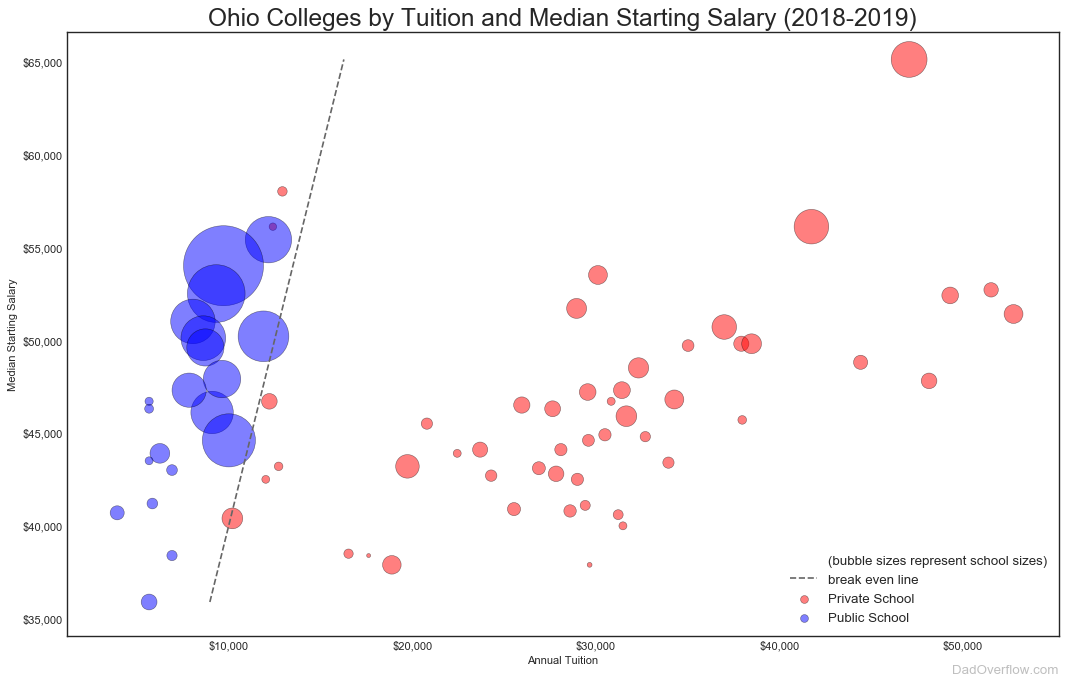

In [5]:
title = 'Ohio Colleges by Tuition and Median Starting Salary (2018-2019)'
fig, ax = plt.subplots(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')

_ = ax.scatter('Tuition', 'Early Career', data=df_oh_schools_merged[df_oh_schools_merged.private_school], 
                s='div_school_size', c='r', label='Private School', edgecolors='black', linewidths=.5, alpha=0.5)
_ = ax.scatter('Tuition', 'Early Career', data=df_oh_schools_merged[~df_oh_schools_merged.private_school], 
                s='div_school_size', c='b', label='Public School', edgecolors='black', linewidths=.5, alpha=0.5)

# sneaky way to add note to legend
ax.plot([], [], ' ', label="(bubble sizes represent school sizes)")

min_sal = df_oh_schools_merged['Early Career'].min()
max_sal = df_oh_schools_merged['Early Career'].max()

# break even line
ax.plot([min_sal/4, max_sal/4], [min_sal, max_sal], '--', color='0.40', label='break even line')

plt.title(title, fontsize=22)
lgnd = plt.legend(fontsize=12, loc='lower right')
#change the marker size manually for both lines
lgnd.legendHandles[2]._sizes = [50]
lgnd.legendHandles[3]._sizes = [50]

plt.xlabel('Annual Tuition')
plt.ylabel('Median Starting Salary')

# format x and y axis ticks
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick)
ax.yaxis.set_major_formatter(tick)

fig.text(0.9, 0.075, 'DadOverflow.com',
         fontsize=12, color='gray',
         ha='right', va='bottom', alpha=0.5)

plt.show()

#### Now, I really want to know which schools are the better returns on investment and which ones are the worst, according to what I've depicted above.  However, I don't want to muddy up my nice chart labeling each bubble.  So, I'll calculate the distance of each bubble from my break even line.  Positive values have a positive return on investment whereas negative distances depict a negative return on investment.

In [6]:
# reference:
# https://stackoverflow.com/questions/39840030/distance-between-point-and-a-line-from-two-points

p1 = np.asarray((min_sal/4, min_sal))
p2 = np.asarray((max_sal/4, max_sal))

def calc_break_even_distance(tuition, salary):
    p3 = np.asarray((tuition, salary))
    return np.cross(p2-p1, p3-p1)/norm(p2-p1)


df_oh_schools_merged['be_dist'] = df_oh_schools_merged.apply(lambda r: calc_break_even_distance(r.Tuition, 
                                                                                                r['Early Career']), axis=1)

df_oh_schools_merged.head()

,Rank,School Name,School Type,Degree Type,School Sector,Mid-Career PayMedian salary for alumni with 10+ years experience,% High Meaning% alumni who say their work makes the world a better place,"% STEM Degrees% degrees awarded in science, technology, engineering or math subjects",Early Career,private_school,Tuition,Rating,$Value,School Size,div_school_size,be_dist
0,1,Case Western Reserve University,"Private School, Research University",Bachelors,Private not-for-profit,"$113,800",45%,36%,65100,True,47074.0,93,68,10398.0,1039.8,-29879.418862
1,2,Kenyon College,"Liberal Arts School, Private School",Bachelors,Private not-for-profit,"$111,500",49%,17%,52700,True,51540.0,95,72,1689.0,168.9,-37219.517018
2,3,Wittenberg University,"Liberal Arts School, Private School, Religious",Bachelors,Private not-for-profit,"$109,800",61%,20%,49800,True,37930.0,-,-,1866.0,186.6,-24719.230904
3,4,Denison University,"Liberal Arts School, Private School",Bachelors,Private not-for-profit,"$108,200",44%,22%,52400,True,49310.0,90,67,2259.0,225.9,-35128.859930
4,5,Miami University,"Research University, For Sports Fans, State Sc...",Bachelors,Public,"$108,100",46%,22%,55400,False,12168.0,79,72,17399.0,1739.9,1631.779685


In [7]:
print('Top 5 biggest ROI schools: \n{0}'.format( df_oh_schools_merged[df_oh_schools_merged.be_dist>0].sort_values('be_dist', ascending=False)['School Name'].head()))
print('\nTop 5 least ROI schools: \n{0}'.format( df_oh_schools_merged[df_oh_schools_merged.be_dist<0].sort_values('be_dist')['School Name'].head()))

Top 5 biggest ROI schools: 
68              Central State University
40        Kent State University at Salem
45     Kent State University at Trumbull
56    Kent State University at Ashtabula
46              Shawnee State University
Name: School Name, dtype: object

Top 5 least ROI schools: 
8              Oberlin College
1               Kenyon College
3           Denison University
18      The College of Wooster
6     Ohio Wesleyan University
Name: School Name, dtype: object
